In [22]:
#if need to delete all variable
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [23]:
%pylab inline
import skimage.io as sk
import imageio
import ipywidgets as wdg
import skan
from pathlib import Path
import pandas as pd


Populating the interactive namespace from numpy and matplotlib


In [24]:
path = Path('/mnt/7149C4F67F3305B7/Rishabh/Tomography_Data/PZ103/Subtractions/')
fsuffix = 'PZ103_01-48.tif' #It can be a list in Path folder


file = Path(path.resolve(), fsuffix)
full_img = sk.imread(str(file), as_gray=False)

In [25]:
print(np.shape(full_img))
img = full_img[126:824]
print(np.shape(img))


(959, 251, 251)
(698, 251, 251)


### Choosing a point of wormhole to extract it from grayscale difference image

In [26]:
z = 590

In [5]:
%matplotlib tk
fig = figure(figsize=(7,7))

imshow(img[z], cmap="gray")
x = 0; y = 0

def onclick(event):
    global x
    global y
    close()
    x = int((event.xdata))
    y = int((event.ydata))
    print(x,y)

ka = fig.canvas.mpl_connect('button_press_event', onclick)


130 75


In [6]:
fig.canvas.mpl_disconnect(ka)
point = [z, x, y]

In [27]:
### To use mavayi give point manually
x = 130; y = 75;
point = [z, y, x]

### For testing the range of threshold values

In [28]:
grayselected = img[z, y, x]
graythresh = 550
mask = img >= graythresh

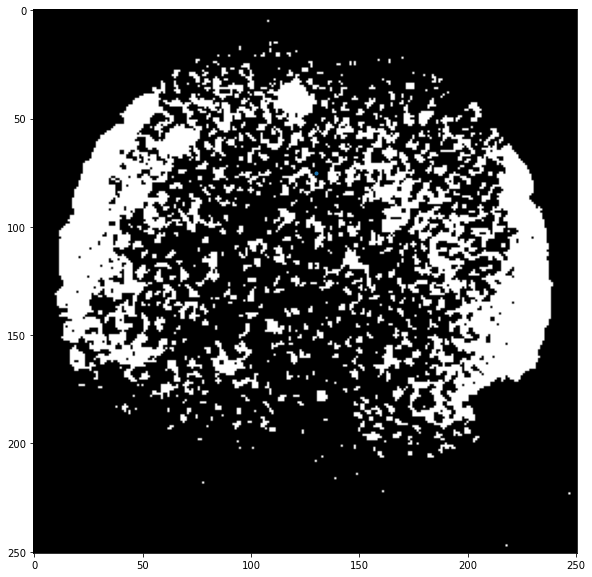

In [29]:
%matplotlib inline
fig = figure(figsize=(10,10))
imshow(mask[0], cmap="gray")
plot(x, y, ".")
show()

In [30]:
import time
from skimage import measure, morphology, segmentation
import scipy.ndimage.morphology as morph 


start =time.time()
whmask = segmentation.flood(mask, (z, y, x), connectivity=1)
filled_wormhole = morph.binary_fill_holes(whmask)
end =time.time()
print(end-start)

2.034085273742676


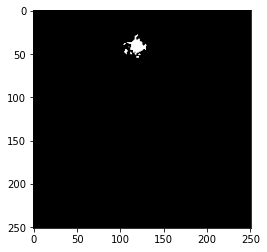

In [31]:
imshow(filled_wormhole[1], cmap="gray")
show()

In [30]:
vox_vol = filled_wormhole.sum()
vox_size = 169
print("Wormhole volume: " + str(vox_vol*(1*vox_size)**3/1000**3/10**3) + " cm3 ") # Volume in cm^3
#print(11.5*pi*(3.83/2)**2) # Volume of sample
print(vox_vol) # Volume of scan

Wormhole volume: 1.191628125493 cm3 
246877


### Save the TIFF stack

In [83]:
from tifffile import imsave
imsave(fsuffix, filled_wormhole)

### Or Render it with MAYAVI

In [19]:
from mayavi import mlab
contour_wormhole = filled_wormhole.astype(int)

In [20]:
mlab.pipeline.volume(mlab.pipeline.scalar_field(contour_wormhole))
mlab.show()

### ============================ Testing finished here =====================================

### Calculating variation of Volume with Threshold based on difference images

In [54]:
import sys
sys.path.append('../')
import lib.Geometric_properties_of_wormhole as GPM

In [55]:
#Reload modules
import importlib
importlib.reload(GPM)

<module 'lib.Geometric_properties_of_wormhole' from '../lib/Geometric_properties_of_wormhole.py'>

In [30]:
step = 10;
sample = GPM.Wormhole_from_tomography(img, suffix = fsuffix, voxel_size = 169, downscaling_factor=1)

In [31]:
from tqdm import tqdm
list_thresold = range(300, 3000, step)
Vol = [];



for th_value in tqdm(list_thresold):
        # Finding the wormhole
    Vol_unfill, wormhole_unfilled = sample.Connected_components_extraction(th_value=th_value, point=point)

    #Filling the holes and calculatin volume
    Vol_fill, wormhole_filled = sample.Fill_holes_in_wormhole()
    
    Vol.append(Vol_fill)

100%|██████████| 270/270 [08:48<00:00,  1.96s/it]


In [51]:
Vol

[19793986, 18710407, 17609902, 16476623, 15300806]

### Convert to Pandas framework

In [32]:
fill_Vol = [Vol[i] for i in range(len(Vol))]
dict = {'Threshold_value': list_thresold, 'Volume': fill_Vol}
df = pd.DataFrame(dict)

### ======================= Saving data to csv file to avoid long computation =======================

In [48]:
df.to_csv(fsuffix.strip('.tif') +'.csv')

### ============= Or loading threshold and volume from csv file for big data ===================

In [5]:
df = pd.read_csv(fsuffix.strip('.tif') + '.csv')

### =====================================================================================

### Calculating moving average to smooth out the data

In [34]:
mv_avg_Vol = df.rolling(window=1).mean()
Vol_new = mv_avg_Vol['Volume']
list_thresold = mv_avg_Vol['Threshold_value']

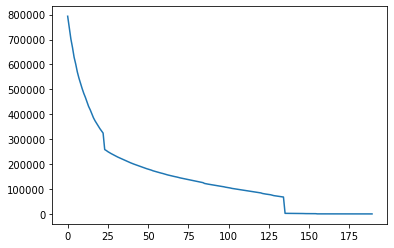

In [39]:
plt.plot(Vol_new[:190])


### Calculating derivatives same as calcualted from function

In [40]:
#derV = [-(Vol_new[i] - Vol_new[i+1])/step for i in range(len(Vol_new)-1)] #First Derivative
der1V = [-(Vol_new[i] - Vol_new[i+1])/step for i in range(len(Vol_new)-1)]
der2V = [(der1V[i] - der1V[i+1])/step for i in range(len(der1V)-1)] #Second derivative

Text(0, 0.5, 'Derivative-2')

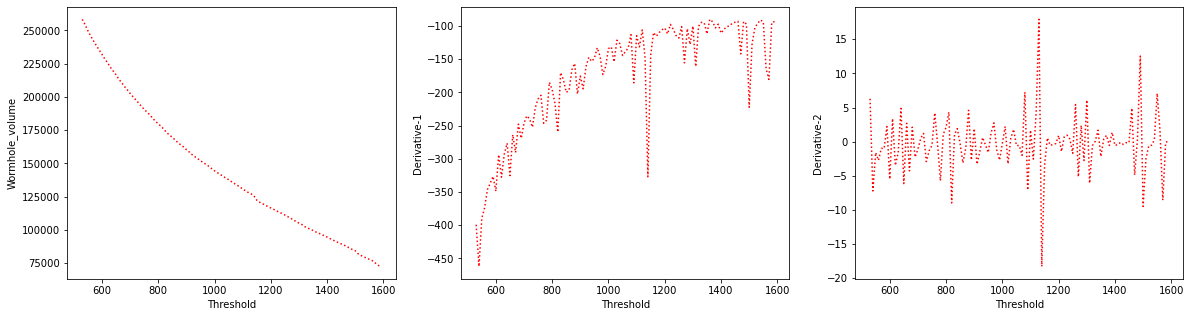

In [52]:
%matplotlib inline
ind_start = 23;
ind_end = 130;

fig, ax = plt.subplots(ncols = 3, figsize=[20,5])
ax[0].plot(list_thresold[ind_start:ind_end], Vol_new[ind_start:ind_end], 'r:')
ax[0].set_xlabel('Threshold')
ax[0].set_ylabel('Wormhole_volume')

ax[1].plot(list_thresold[ind_start:ind_end], der1V[ind_start:ind_end], 'r:')
ax[1].set_xlabel('Threshold')
ax[1].set_ylabel('Derivative-1')

ax[2].plot(list_thresold[ind_start:ind_end], der2V[ind_start:ind_end], 'r:')
ax[2].set_xlabel('Threshold')
ax[2].set_ylabel('Derivative-2')

#plt.savefig("PZ_17_diff_VolumevsThrehosld_variation.jpg")

In [15]:
from lib.Geometric_properties_of_wormhole import find_threshold_with_10_percent_volume_decrement, find_linear_region_of_curve

In [63]:
tmp = find_linear_region_of_curve(Vol_new[:190], 
                                  window_of_linearity = 10, 
                                  closeness_to_zero_derv_one = 400, 
                                  closeness_to_zero_derv_two = 10,
                                  step = 10)

print(tmp,  der2V[tmp],  list_thresold[tmp])

Region of interest starts from 23
Linear section found
25 -1.6100000000000023 550.0


In [31]:
th_index = find_threshold_with_10_percent_volume_decrement(Vol_new[:190], Min_Threshold_index=tmp)

In [32]:
for i in th_index:
    print(list_thresold[i])

545.0
665.0
825.0
1025.0


## Extraction of Wormhole

### Without Median Filter

In [9]:
import sys
sys.path.append('../')
import lib.Geometric_properties_of_wormhole as GPM

In [10]:
#Reload modules
import importlib
importlib.reload(GPM)

<module 'lib.Geometric_properties_of_wormhole' from '../lib/Geometric_properties_of_wormhole.py'>

In [11]:
sample = GPM.Wormhole_from_tomography(img, suffix = fsuffix, voxel_size = 169, downscaling_factor=1)

In [12]:
th_value = 550
# Finding the wormhole

Vol_unfill, wormhole_unfilled = sample.Connected_components_extraction(th_value=th_value, point=point)

#Filling the holes and calculatin volume
Vol_fill, wormhole_filled = sample.Fill_holes_in_wormhole()

#Calculating Surface area and Volume in voxels as well as cm scale
SA = sample.Surface_area_Legland_et_al()
Vol_cm, SA_cm = sample.Volume_and_Surface_area_Cm2()


In [14]:
sample.Skeletonise_the_wormhole()
sample.info

Finding dominant wormhole
%=====================Looking for Inlet node=========================%

Node-0is not connected to main wormhole
Node-1 is connected and chosen as source node
%=====================Looking for Outlet node=========================%


 Node-3257 is connected and chosen as outlet node


{'File_name': 'PZ103_01-49.tif',
 'voxel_size': 169,
 'downscaling_factor': 1,
 'Volume_in_voxel': 246877,
 'Volume in cm3': 1.191628125493,
 'Surface_area_in_voxel': 149281.78507607337,
 'Surface_area_in_cm2': 0.42636370635577314,
 'Length_of_wormhole': 1430.5519357504475,
 'Tortuosity': 2.0524418016505703,
 'Wastefullness': 13.308512666981715}

In [13]:
Vol_fill

246877